#### Se importan las librerias necesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#### Se carga la información del csv principal a un dataframe.

In [2]:
tweets = pd.read_csv('../TP1-Organizacion-de-Datos/csv/train.csv')
tweets.sample(n=5)

,id,keyword,location,text,target
1450,2091,casualty,NaN,@5SOSFamUpdater social casualty,0
1017,1477,body%20bagging,EPTX,@SlikRickDaRula Drake really body bagging peep...,0
3990,5669,floods,Û¢III.XII.MMXIÛ¢,Granted like half my town floods when it rains...,1
2093,3009,death,PROV,Death threats on a nigga life well then we gon...,0
4153,5902,harm,i love you zayn,If anything happens I will fucking fly 2 MetLi...,0


##### Se reemplaza la columna 'target' por 'about_disaster' para mayor comodidad y se agrega 'length'

In [3]:
tweets_final = tweets.rename(columns={'target':'about_disaster'})
tweets_final['about_disaster'] = ((tweets_final['about_disaster'])==1)
tweets_final['length'] = (tweets_final['text']).str.len()
tweets_final.head()

,id,keyword,location,text,about_disaster,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,True,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,True,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,True,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",True,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,True,88


# Veracidad por keyword

In [4]:
tweets_final['keyword'].fillna("none_keyword", inplace=True)

#### Se agrupa por keyword y se calcula valores relevantes a lo que se busca estudiar (cantidad de tweets veraces y totales, y longitud promedio de los tweets totales, veraces y no veraces por keyword).

In [5]:
tweets_por_keyword = tweets_final.groupby(['keyword']).agg({'about_disaster':['sum','count'],'length':['mean']})
tweets_por_keyword.head()

about_disaster            length
                               sum count        mean
keyword                                             
ablaze                        13.0    36   94.694444
accident                      24.0    35  100.085714
aftershock                     0.0    34  101.205882
airplane%20accident           30.0    35  106.400000
ambulance                     20.0    38   98.394737

In [6]:
tweets_por_keyword.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222 entries, ablaze to wrecked
Data columns (total 3 columns):
(about_disaster, sum)      222 non-null float64
(about_disaster, count)    222 non-null int64
(length, mean)             222 non-null float64
dtypes: float64(2), int64(1)
memory usage: 6.9+ KB


#### Se elimina el MultiIndex

In [7]:
nivel0 = tweets_por_keyword.columns.get_level_values(0)
nivel1 = tweets_por_keyword.columns.get_level_values(1)
tweets_por_keyword.columns = nivel0 + '_' + nivel1
tweets_por_keyword.head()

,about_disaster_sum,about_disaster_count,length_mean
keyword,,,
ablaze,13.0,36,94.694444
accident,24.0,35,100.085714
aftershock,0.0,34,101.205882
airplane%20accident,30.0,35,106.400000
ambulance,20.0,38,98.394737


#### Se renombran y reordenan las columnas para mayor claridad

In [8]:
nuevos_nombres = {'about_disaster_sum':'about_disaster_true', 'about_disaster_count':'count'}
tweets_por_keyword.rename(columns=nuevos_nombres, inplace=True)
tweets_por_keyword.head()

,about_disaster_true,count,length_mean
keyword,,,
ablaze,13.0,36,94.694444
accident,24.0,35,100.085714
aftershock,0.0,34,101.205882
airplane%20accident,30.0,35,106.400000
ambulance,20.0,38,98.394737


In [9]:
tweets_por_keyword['about_disaster_false'] = tweets_por_keyword['count'] - tweets_por_keyword['about_disaster_true']
tweets_por_keyword['veracity'] =  tweets_por_keyword['about_disaster_true']/tweets_por_keyword['count']
tweets_por_keyword = tweets_por_keyword[['about_disaster_true', 'about_disaster_false', 'count', 'veracity', 'length_mean']]
tweets_por_keyword.sort_values(by='veracity', ascending=False, inplace=True)
tweets_por_keyword.head(10)

,about_disaster_true,about_disaster_false,count,veracity,length_mean
keyword,,,,,
wreckage,39.0,0.0,39,1.000000,122.256410
derailment,39.0,0.0,39,1.000000,109.794872
debris,37.0,0.0,37,1.000000,107.594595
outbreak,39.0,1.0,40,0.975000,128.925000
typhoon,37.0,1.0,38,0.973684,111.394737
oil%20spill,37.0,1.0,38,0.973684,102.973684
suicide%20bombing,32.0,1.0,33,0.969697,108.575758
suicide%20bomber,30.0,1.0,31,0.967742,109.032258
bombing,27.0,2.0,29,0.931034,102.482759


#### Se observa el promedio de tweets por keyword para filtrar aquellas que obstruyan el análisis estadístico

In [10]:
tweets_por_keyword['count'].mean()

34.292792792792795

In [11]:
tweets_por_keyword[tweets_por_keyword['count']<34].count()

about_disaster_true     77
about_disaster_false    77
count                   77
veracity                77
length_mean             77
dtype: int64

#### Al enfocar el análisis estadístico a aquellas keywords que posean 34 o más tweets, se dejan de lado 77 keywords (alrededor del 35% del total).

In [12]:
tweets_por_keyword['count'].value_counts()

35    31
34    30
33    26
36    20
37    19
38    16
32    15
39    14
31     9
29     8
40     7
30     6
41     4
42     2
28     2
27     2
22     1
10     1
11     1
12     1
19     1
61     1
24     1
25     1
26     1
45     1
9      1
Name: count, dtype: int64

In [13]:
tweets_por_keyword[tweets_por_keyword['count']<29].count()

about_disaster_true     13
about_disaster_false    13
count                   13
veracity                13
length_mean             13
dtype: int64

#### Al enfocarse en aquellas que tienen 29 o más tweets, el espectro estudiado aumenta claramente. Además, en este caso, 29 no es una diferencia significativa del promedio.

In [14]:
keywords_veraces = (tweets_por_keyword[tweets_por_keyword['count']>=29]).head(20)
keywords_no_veraces = (tweets_por_keyword[tweets_por_keyword['count']>=29]).tail(20)

#### Se procede a graficar

Text(0.5, 1.0, 'Top 20 Keywords con mejor porcentaje de veracidad')

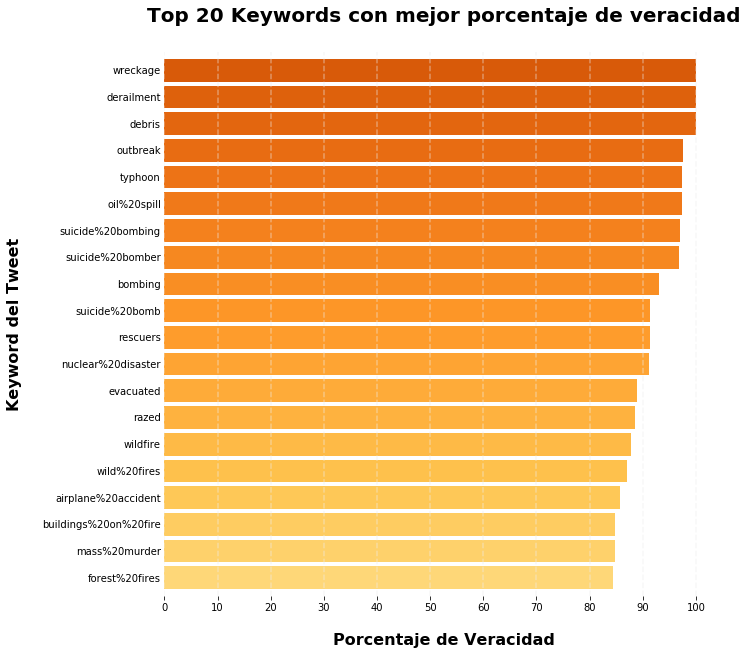

In [15]:
saltos = np.linspace(0.3, 0.7, 20)
colores = (cm.get_cmap('YlOrBr'))(saltos)
top20 = (keywords_veraces['veracity']*100).sort_values().plot(kind='barh', figsize=(10,10), color=colores, width=0.85)

plt.xticks(np.arange(0, 100+1, 10.0))
plt.tick_params(axis='y', length=0)

top20.spines['right'].set_visible(False)
top20.spines['top'].set_visible(False)
top20.spines['left'].set_visible(False)
top20.spines['bottom'].set_visible(False)

lineas = top20.get_xticks()
for i in lineas:
      top20.axvline(x=i, linestyle='--', alpha=0.4, color='#eeeeee')
        
top20.set_xlabel("Porcentaje de Veracidad", labelpad=20, weight='bold', size=16)
top20.set_ylabel("Keyword del Tweet", labelpad=20, weight='bold', size=16)

plt.title("Top 20 Keywords con mejor porcentaje de veracidad", weight='bold', size=20, pad=30)

Text(0.5, 1.0, 'Top 20 Keywords con peor porcentaje de veracidad')

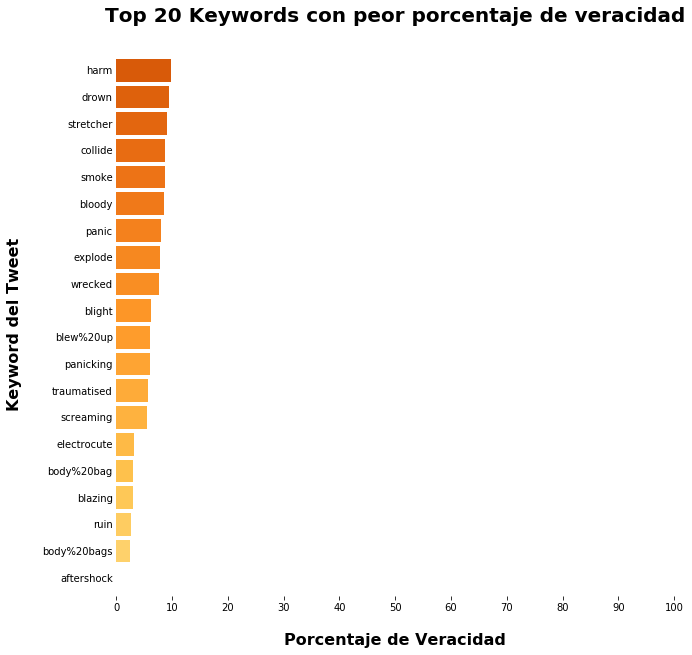

In [16]:
worst20 = (keywords_no_veraces['veracity']*100).sort_values().plot(kind='barh', figsize=(10,10), color=colores, width=0.85)

plt.xticks(np.arange(0, 100+1, 10.0))
plt.tick_params(axis='y', length=0)

worst20.spines['right'].set_visible(False)
worst20.spines['top'].set_visible(False)
worst20.spines['left'].set_visible(False)
worst20.spines['bottom'].set_visible(False)

lineas = worst20.get_xticks()
for i in lineas:
      top20.axvline(x=i, linestyle='--', alpha=0.4, color='#eeeeee')
        
worst20.set_xlabel("Porcentaje de Veracidad", labelpad=20, weight='bold', size=16)
worst20.set_ylabel("Keyword del Tweet", labelpad=20, weight='bold', size=16)

plt.title("Top 20 Keywords con peor porcentaje de veracidad", weight='bold', size=20, pad=30)

Text(0.5, 1.0, 'Cantidad de Keywords por porcentaje de veracidad')

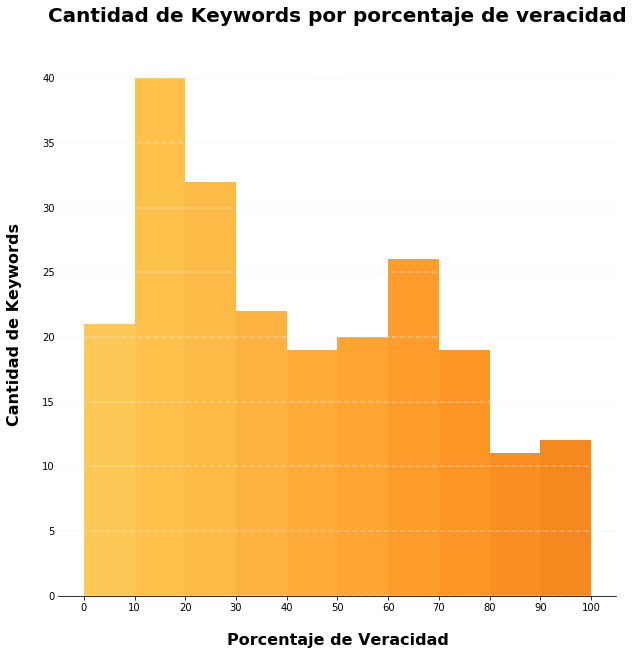

In [17]:
plt.figure(figsize=(10,10))    
n, bins, patches = plt.hist(tweets_por_keyword["veracity"]*100, bins=10, color="c")
hist_porcentajes = plt.gca()

for i,p in enumerate(patches):
    plt.setp(p, "facecolor", colores[i+3])

plt.xticks(np.arange(0, 100+1, 10.0))
plt.yticks(np.arange(0, 40+1, 5.0))
plt.tick_params(axis='y', length=0)

hist_porcentajes.spines['right'].set_visible(False)
hist_porcentajes.spines['top'].set_visible(False)
hist_porcentajes.spines['left'].set_visible(False)

lineas = hist_porcentajes.get_yticks()
for i in lineas:
      hist_porcentajes.axhline(y=i, linestyle='--', alpha=0.4, color='#eeeeee')
        
hist_porcentajes.set_xlabel("Porcentaje de Veracidad", labelpad=20, weight='bold', size=16)
hist_porcentajes.set_ylabel("Cantidad de Keywords", labelpad=20, weight='bold', size=16)

plt.title("Cantidad de Keywords por porcentaje de veracidad", weight='bold', size=20, pad=30)

Text(0.5, 1.0, 'Longitud promedio de los tweets con las 20 keywords más veraces')

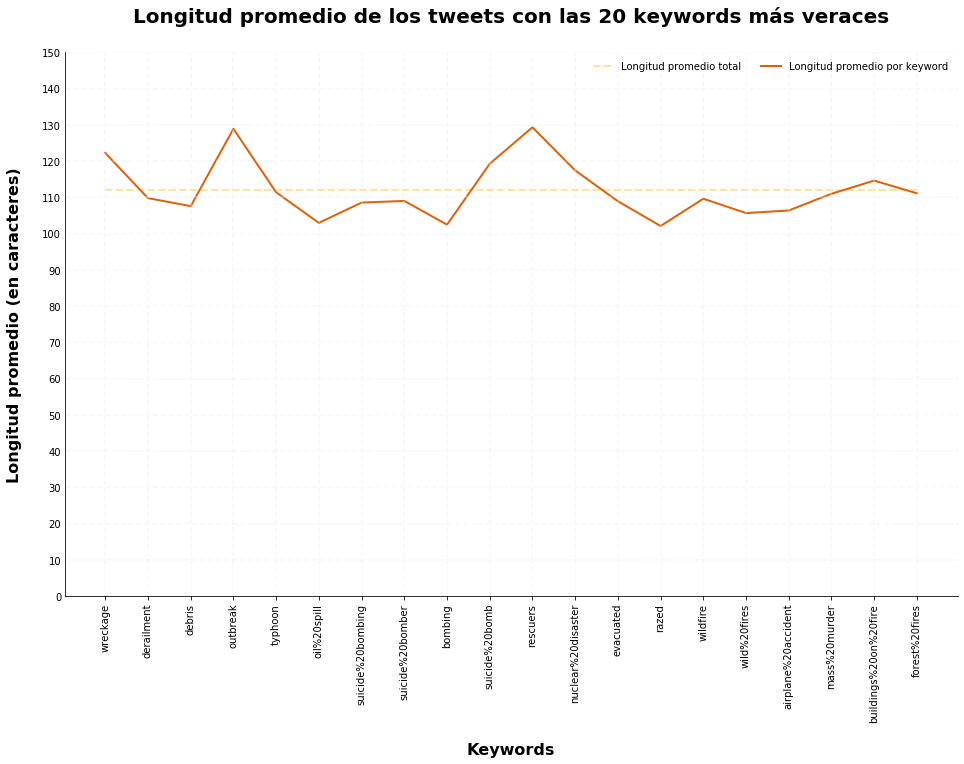

In [18]:
plt.figure(figsize=(16,10)) 
top20_linear = plt.subplot()

saltos_x = np.arange(0, 20, 1.0)
longitud_promedio = [keywords_veraces['length_mean'].mean()]*len(saltos_x)
top20_linear.plot(saltos_x, longitud_promedio, lw=2, color=colores[1], \
                  alpha=0.6, linestyle = '--', label='Longitud promedio total')

top20_linear.plot(keywords_veraces.index.values.tolist(), keywords_veraces['length_mean'],\
                lw=2, color=colores[18], alpha=1, label='Longitud promedio por keyword')

plt.xticks(saltos_x)
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 160, 10.0))

top20_linear.spines['right'].set_visible(False)
top20_linear.spines['top'].set_visible(False)
plt.tick_params(axis='y', length=0)

lineas_x = top20_linear.get_xticks()
for i in lineas_x:
      top20_linear.axvline(x=i, linestyle='--', alpha=0.4, color='#eeeeee')
        
lineas_y = top20_linear.get_yticks()
for i in lineas_y:
      top20_linear.axhline(y=i, linestyle='--', alpha=0.4, color='#eeeeee')
        
        
        
top20_linear.set_xlabel("Keywords", labelpad=20, weight='bold', size=16)
top20_linear.set_ylabel("Longitud promedio (en caracteres)", labelpad=20, weight='bold', size=16)

top20_linear.legend(frameon=False, loc='best', ncol=2)

plt.title("Longitud promedio de los tweets con las 20 keywords más veraces", weight='bold', size=20, pad=30)

Text(0.5, 1.0, 'Longitud promedio de los tweets con las 20 keywords menos veraces')

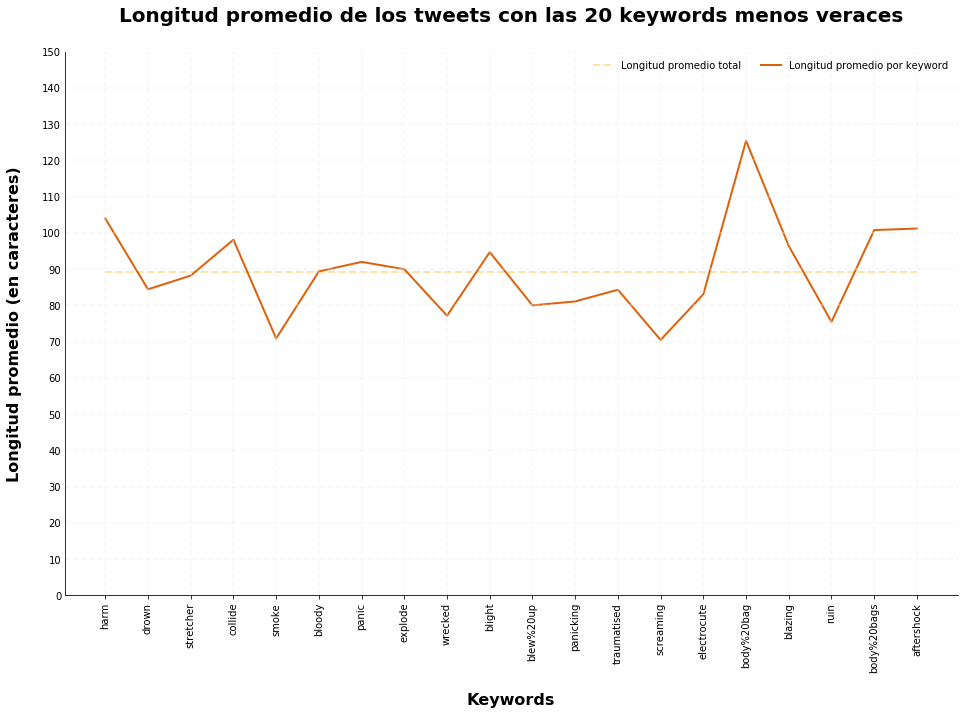

In [19]:
plt.figure(figsize=(16,10)) 
worst20 = plt.subplot()

saltos_x = np.arange(0, 20, 1.0)
longitud_promedio = [keywords_no_veraces['length_mean'].mean()]*len(saltos_x)
worst20.plot(saltos_x, longitud_promedio, lw=2, color=colores[1], \
                  alpha=0.6, linestyle = '--', label='Longitud promedio total')

worst20.plot(keywords_no_veraces.index.values.tolist(), keywords_no_veraces['length_mean'],\
                lw=2, color=colores[18], alpha=1, label='Longitud promedio por keyword')


plt.xticks(saltos_x)
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 160, 10.0))

worst20.spines['right'].set_visible(False)
worst20.spines['top'].set_visible(False)
plt.tick_params(axis='y', length=0)

lineas_x = worst20.get_xticks()
for i in lineas_x:
      worst20.axvline(x=i, linestyle='--', alpha=0.4, color='#eeeeee')
        
lineas_y = worst20.get_yticks()
for i in lineas_y:
      worst20.axhline(y=i, linestyle='--', alpha=0.4, color='#eeeeee')
        
worst20.set_xlabel("Keywords", labelpad=20, weight='bold', size=16)
worst20.set_ylabel("Longitud promedio (en caracteres)", labelpad=20, weight='bold', size=16)

worst20.legend(frameon=False, loc='best', ncol=2)

plt.title("Longitud promedio de los tweets con las 20 keywords menos veraces", weight='bold', size=20, pad=30)

# Relación de veracidad y longitud con palabras/caracteres específicos

#### Se buscará estudiar si existe una relación de los tweets que contienen nombres de ciudades/países, los que comienzan con mayúsculas, incluyen URLs o poseen los caracteres '#', '@', '¿?', '¡!', con la veracidad y longitud de los mismos. 

#### Se comienza leyendo el archivo de locaciones que se buscarán en los tweets.

In [20]:
ciudades = pd.read_csv('../TP1-Organizacion-de-Datos/csv/worldcities.csv')

In [21]:
ciudades.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6850,139.7514,Japan,JP,JPN,Tōkyō,primary,35676000.0,1392685764
1,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,19354922.0,1840034016
2,Mexico City,Mexico City,19.4424,-99.1310,Mexico,MX,MEX,Ciudad de México,primary,19028000.0,1484247881
3,Mumbai,Mumbai,19.0170,72.8570,India,IN,IND,Mahārāshtra,admin,18978000.0,1356226629
4,São Paulo,Sao Paulo,-23.5587,-46.6250,Brazil,BR,BRA,São Paulo,admin,18845000.0,1076532519


In [22]:
ciudad = ciudades['city_ascii'].str.lower()
paises = ciudades['country'].drop_duplicates().str.lower()
#iso2 = ciudades['iso2'].drop_duplicates().str.lower()
#iso3 = ciudades['iso3'].drop_duplicates().str.lower()
locaciones = pd.concat([ciudad, paises])
locaciones.count()

15716

#### Se crea el dataframe a utilizar para el estudio

In [23]:
elementos = ['#', '@', '¡,!', '¿,?', 'URL (http)', 'Locación', 'Comienza con mayúscula']
caracteristicas = pd.DataFrame(index=elementos)
caracteristicas

""
#
@
"¡,!"
"¿,?"
URL (http)
Locación
Comienza con mayúscula


In [24]:
caracteristicas['ocurrencias'] = 0
caracteristicas['ocurrencias_verd'] = 0
caracteristicas['long_prom'] = 0
caracteristicas['long_prom_verd'] = 0
caracteristicas['long_prom_falsos'] = 0
caracteristicas.head()

,ocurrencias,ocurrencias_verd,long_prom,long_prom_verd,long_prom_falsos
#,0,0,0,0,0
@,0,0,0,0,0
"¡,!",0,0,0,0,0
"¿,?",0,0,0,0,0
URL (http),0,0,0,0,0


#### Además, se crea un dataframe auxiliar para realizar las búsquedas

In [25]:
auxiliar = tweets_final.iloc[:,3:6]
auxiliar.head()

,text,about_disaster,length
0,Our Deeds are the Reason of this #earthquake M...,True,69
1,Forest fire near La Ronge Sask. Canada,True,38
2,All residents asked to 'shelter in place' are ...,True,133
3,"13,000 people receive #wildfires evacuation or...",True,65
4,Just got sent this photo from Ruby #Alaska as ...,True,88


#### Se definen las funciones buscadores de caracteres y ciudades.

In [26]:
def valores_calculados(auxiliar):
    encontrados = auxiliar['contains_element'].sum()
    verdaderos = auxiliar[auxiliar['about_disaster']==True]['contains_element'].sum()
    longitud = auxiliar[auxiliar['contains_element']==True]['length'].mean()
    longitud_verdaderos = auxiliar[(auxiliar['contains_element']==True) & (auxiliar['about_disaster']==True)]['length'].mean()
    longitud_falsos = auxiliar[(auxiliar['contains_element']==True) & (auxiliar['about_disaster']==False)]['length'].mean()
    return encontrados, verdaderos, longitud, longitud_verdaderos, longitud_falsos

In [27]:
def buscar_caracteres(caracter1, caracter2=""):
    if caracter2 == "":
        auxiliar['contains_element'] = auxiliar['text'].str.contains(caracter1) 
    else: 
        auxiliar['contains_element'] = auxiliar['text'].str.contains('|'.join([caracter1, caracter2]))    
    return valores_calculados(auxiliar)

In [28]:
def buscar_inicial():
    iniciales = auxiliar['text'].str.slice(stop=1)
    auxiliar['contains_element'] = iniciales.str.isupper()
    return valores_calculados(auxiliar)    

In [29]:
# ejecutar luego de buscar_inicial, se puede arreglar pero son las 5am
def buscar_locaciones():
    auxiliar['contains_element'] = False
    auxiliar['text'] = auxiliar['text'].str.lower()
    for locacion in locaciones:
        auxiliar.loc[auxiliar['contains_element']==False, ['contains_element']] = (auxiliar.loc[auxiliar['contains_element']==False]['text']).str.contains(locacion, regex=False)
                
    return valores_calculados(auxiliar)

####  Se completa el dataframe

In [30]:
caracteristicas.loc['#',:] = buscar_caracteres('#')
caracteristicas.loc['@',:] =  buscar_caracteres('@')
caracteristicas.loc['¿,?',:] =  buscar_caracteres('\?', '¿')
caracteristicas.loc['¡,!',:] =  buscar_caracteres('!', '¡')
caracteristicas.loc['URL (http)',:] = buscar_caracteres('http')
caracteristicas.head()

,ocurrencias,ocurrencias_verd,long_prom,long_prom_verd,long_prom_falsos
#,1761,875,113.893242,116.859429,110.963883
@,2039,676,101.921040,109.664201,98.080704
"¡,!",721,197,104.717060,109.045685,103.089695
"¿,?",1042,292,92.758157,99.993151,89.941333
URL (http),3971,2172,110.103500,111.693831,108.183435


In [31]:
caracteristicas.loc['Comienza con mayúscula',:] = buscar_inicial()
caracteristicas

,ocurrencias,ocurrencias_verd,long_prom,long_prom_verd,long_prom_falsos
#,1761,875,113.893242,116.859429,110.963883
@,2039,676,101.921040,109.664201,98.080704
"¡,!",721,197,104.717060,109.045685,103.089695
"¿,?",1042,292,92.758157,99.993151,89.941333
URL (http),3971,2172,110.103500,111.693831,108.183435
Locación,0,0,0.000000,0.000000,0.000000
Comienza con mayúscula,4911,2239,101.293219,107.351943,96.216317


In [32]:
caracteristicas.loc['Locación',:] = buscar_locaciones()
caracteristicas

,ocurrencias,ocurrencias_verd,long_prom,long_prom_verd,long_prom_falsos
#,1761,875,113.893242,116.859429,110.963883
@,2039,676,101.921040,109.664201,98.080704
"¡,!",721,197,104.717060,109.045685,103.089695
"¿,?",1042,292,92.758157,99.993151,89.941333
URL (http),3971,2172,110.103500,111.693831,108.183435
Locación,6938,3103,104.780628,110.162101,100.426336
Comienza con mayúscula,4911,2239,101.293219,107.351943,96.216317


In [33]:
caracteristicas['ocurrencias_falsas'] = caracteristicas['ocurrencias']-caracteristicas['ocurrencias_verd']

In [34]:
caracteristicas['veracidad'] = caracteristicas['ocurrencias_verd']/caracteristicas['ocurrencias']
caracteristicas

,ocurrencias,ocurrencias_verd,long_prom,long_prom_verd,long_prom_falsos,ocurrencias_falsas,veracidad
#,1761,875,113.893242,116.859429,110.963883,886,0.496877
@,2039,676,101.921040,109.664201,98.080704,1363,0.331535
"¡,!",721,197,104.717060,109.045685,103.089695,524,0.273232
"¿,?",1042,292,92.758157,99.993151,89.941333,750,0.280230
URL (http),3971,2172,110.103500,111.693831,108.183435,1799,0.546965
Locación,6938,3103,104.780628,110.162101,100.426336,3835,0.447247
Comienza con mayúscula,4911,2239,101.293219,107.351943,96.216317,2672,0.455915


#### Se reordena el dataframe

In [35]:
caracteristicas = caracteristicas[['ocurrencias_verd', 'ocurrencias_falsas', 'ocurrencias', 'veracidad', 'long_prom', 'long_prom_verd', 'long_prom_falsos']]
caracteristicas

,ocurrencias_verd,ocurrencias_falsas,ocurrencias,veracidad,long_prom,long_prom_verd,long_prom_falsos
#,875,886,1761,0.496877,113.893242,116.859429,110.963883
@,676,1363,2039,0.331535,101.921040,109.664201,98.080704
"¡,!",197,524,721,0.273232,104.717060,109.045685,103.089695
"¿,?",292,750,1042,0.280230,92.758157,99.993151,89.941333
URL (http),2172,1799,3971,0.546965,110.103500,111.693831,108.183435
Locación,3103,3835,6938,0.447247,104.780628,110.162101,100.426336
Comienza con mayúscula,2239,2672,4911,0.455915,101.293219,107.351943,96.216317


#### Se procede a graficar las relaciones deseadas

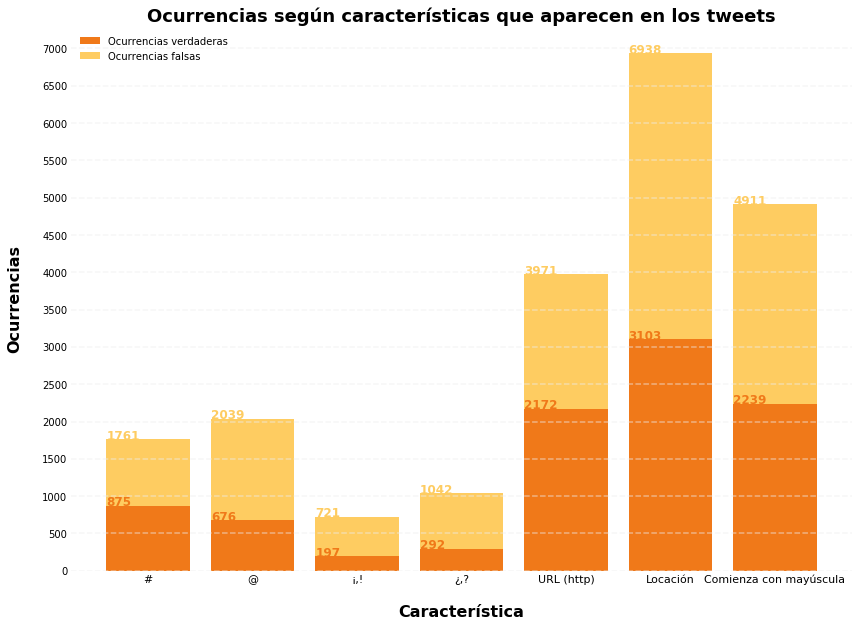

In [36]:
plt.figure(figsize=(14,10))
ocurrencias = plt.subplot()

x = caracteristicas.index.to_list()
ocurr_verd = caracteristicas['ocurrencias_verd']
ocurr_falsas = caracteristicas['ocurrencias_falsas']

ocurrencias.bar(x=x, height=ocurr_verd, color=colores[14], label = 'Ocurrencias verdaderas')
ocurrencias.bar(x=x, height=ocurr_falsas, bottom=ocurr_verd, color= colores[2], label = 'Ocurrencias falsas')

saltos_y = np.linspace(0, 7000, 15)
plt.yticks(saltos_y)
plt.xticks(fontsize = 11)

ocurrencias.spines['right'].set_visible(False)
ocurrencias.spines['top'].set_visible(False)
ocurrencias.spines['bottom'].set_visible(False)
ocurrencias.spines['left'].set_visible(False)
plt.tick_params(axis='both', length=0)

lineas = ocurrencias.get_yticks()
for i in lineas:
    ocurrencias.axhline(y=i, linestyle='--', alpha=0.5, color='#eeeeee')

for x, y in enumerate(ocurr_verd):
    ocurrencias.text(x-0.4, y + .35, str(y), color=colores[14], fontweight='bold', fontsize=12)

for x, y in enumerate(ocurr_falsas+ocurr_verd):
    ocurrencias.text(x-0.4, y +.35, str(y), color=colores[2], fontweight='bold', fontsize=12)    

ocurrencias.set_xlabel("Característica", labelpad=20, weight='bold', size=16)
ocurrencias.set_ylabel("Ocurrencias", labelpad=20, weight='bold', size=16)
plt.legend(frameon=False, loc='best', fontsize=10)
plt.title("Ocurrencias según características que aparecen en los tweets", weight='bold', size=18)

plt.show()

Text(0.5, 1.0, 'Longitud promedio de los tweets según característica que poseen')

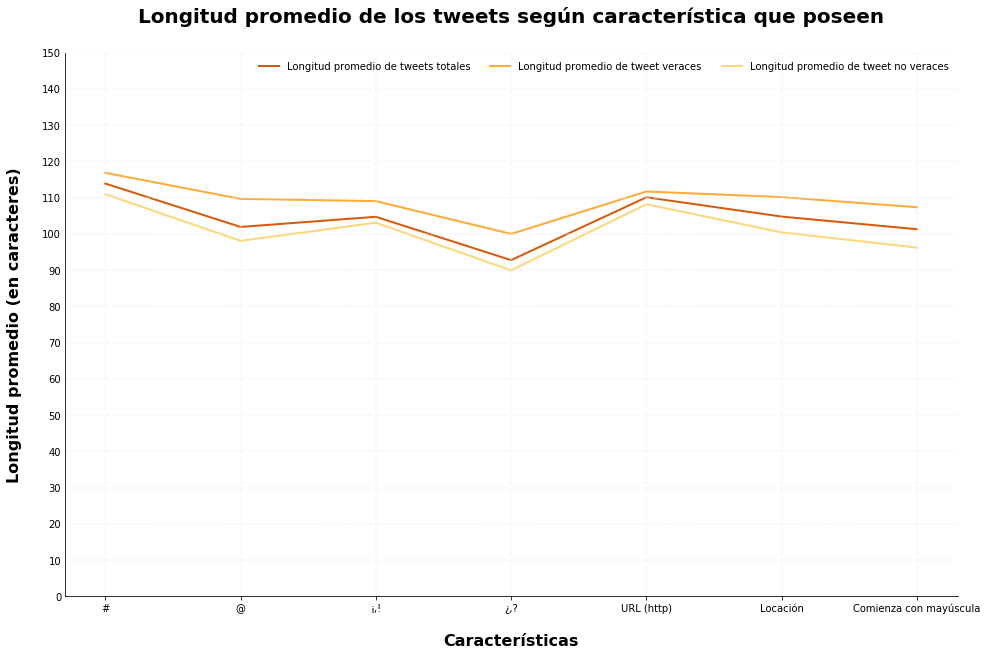

In [39]:
plt.figure(figsize=(16,10)) 
long = plt.subplot()

long.plot(caracteristicas.index.values.tolist(), caracteristicas['long_prom'],\
                lw=2, color=colores[19], alpha=1, label='Longitud promedio de tweets totales')

long.plot(caracteristicas.index.values.tolist(), caracteristicas['long_prom_verd'],\
                lw=2, color=colores[7], alpha=1, label='Longitud promedio de tweet veraces')

long.plot(caracteristicas.index.values.tolist(), caracteristicas['long_prom_falsos'],\
                lw=2, color=colores[0], alpha=1, label='Longitud promedio de tweet no veraces')

plt.yticks(np.arange(0, 160, 10.0))

long.spines['right'].set_visible(False)
long.spines['top'].set_visible(False)
plt.tick_params(axis='y', length=0)

lineas_x = long.get_xticks()
for i in lineas_x:
      long.axvline(x=i, linestyle='--', alpha=0.4, color='#eeeeee')
        
lineas_y = long.get_yticks()
for i in lineas_y:
      long.axhline(y=i, linestyle='--', alpha=0.4, color='#eeeeee')
        
        
        
long.set_xlabel("Características", labelpad=20, weight='bold', size=16)
long.set_ylabel("Longitud promedio (en caracteres)", labelpad=20, weight='bold', size=16)

long.legend(frameon=False, loc='best', ncol=3)

plt.title("Longitud promedio de los tweets según característica que poseen", weight='bold', size=20, pad=30)